# Setup

## Modules

In [1]:
# basic and statistics
import numpy as np
import pandas as pd
import HTfunctions as ht
from statsmodels.formula.api import ols
from scipy import stats
import itertools
import random

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import descartes
from shapely.geometry import Point,Polygon
from matplotlib.lines import Line2D

## Functions

In [2]:
def plotCorrMatrix(corr,figsize=(7,7)):
    matfig = plt.figure(figsize=figsize)
    plt.matshow(corr,cmap="coolwarm",vmin=-1,vmax=1,fignum=matfig.number)
    N = corr.shape[0]
    for col in range(N):
        for row in range(N):
            plt.text(row,col,f"{corr.iloc[col,row]:.2f}",ha="center",va="center")
    plt.xticks(range(N),corr.columns,rotation="vertical")
    plt.yticks(range(N),corr.columns)
    plt.ylim(N-0.5,-0.5)
    plt.xlim(-0.5,N-0.5)
    
def rmse(mod,obs):
    out = np.sqrt(((mod-obs)**2).mean())
    return out

def nse(mod,obs):
    out = 1 - (((mod-obs)**2).sum()/((obs-obs.mean())**2).sum())
    return out

## Data

In [3]:
# getting the snumbers of the catchments
final = ht.openDict("Data/finalSelectionList.pkl")
meta = pd.read_csv("Data/newFinalSelection_1983_2012.csv",index_col=0)
meta.columns

Index(['snumber', 'regine', 'main', 'name', 'stnr', 'start.yr', 'end.yr',
       'missing.yr', 'areal', 'altitude', 'utm.e', 'runoff.region', 'lon',
       'lat', 'AREAL_NOR', 'GRAD_FELT', 'GRAD_ELV', 'HEIGHT_MIN', 'HEIGHT_50',
       'HEIGHT_MAX', 'JORDBRUKPR', 'MYRPRO', 'SKOGPRO', 'BREPRO', 'SJOPRO',
       'SNAUFJPRO'],
      dtype='object')

In [4]:
ht.findFiles("*","Results/dailyMeans")

['Results/dailyMeans/doyMean_rainfall_ost_10dMA_1983_2012.npy',
 'Results/dailyMeans/doyMean_rainfall_vest_10dMA_1983_2012.npy',
 'Results/dailyMeans/doyMean_snowmelt_ost_10dMA_1983_2012.npy',
 'Results/dailyMeans/doyMean_snowmelt_vest_10dMA_1983_2012.npy',
 'Results/dailyMeans/doyMean_streamflow_ost_10dMA_1983_2012.npy',
 'Results/dailyMeans/doyMean_streamflow_vest_10dMA_1983_2012.npy',
 'Results/dailyMeans/doyMean_temperature_ost_10dMA_1983_2012.npy',
 'Results/dailyMeans/doyMean_temperature_vest_10dMA_1983_2012.npy']

In [5]:
# organise all data into dictionary
data = {}
for region in ["ost","vest"]:
    data[region] = {}
    files = ht.findFiles(f"*Mag*{region}*10dMA*1983*","Results/Daily")
    for file in files:
        f = file.split(".")[0]
        var,reg,MA,startYear,endYear = tuple(f.split("_")[1:])
        var = var.replace("Runoff","")
        data[region][var] = np.load(file)
    data[region]["catchments"] = final[region][f"{startYear}-{endYear}"]
    
    bre = []
    for c in data[region]["catchments"]:
        bre.append(float(meta[meta.snumber==c].BREPRO))
    data[region]["glaciation"] = bre
    
    grad = []
    for c in data[region]["catchments"]:
        grad.append(float(meta[meta.snumber==c].GRAD_FELT))
    data[region]["gradient"] = grad
    
    alt = []
    for c in data[region]["catchments"]:
        alt.append(float(meta[meta.snumber==c].altitude))
    data[region]["altitude"] = alt
    
    files = ht.findFiles(f"*{region}*10dMA*1983*","Results/dailyMeans")
    for file in files:
        f = file.split(".")[0]
        var,reg,MA,startYear,endYear = tuple(f.split("_")[1:])
        var = var.replace("Runoff","")
        var = f"mean_{var}"
        data[region][var] = np.load(file)

In [6]:
data["ost"].keys()

dict_keys(['PROstreamflow', 'rainfallCont', 'rainfall', 'snowmeltCont', 'snowmelt', 'streamflow', 'temperature', 'catchments', 'glaciation', 'gradient', 'altitude', 'mean_rainfall', 'mean_snowmelt', 'mean_streamflow', 'mean_temperature'])

In [14]:
# reorganising into dataframes
dfs = {}
dfs["annual"]={}
for region in ["ost","vest"]:
    dfs["annual"][region] = {}
    a = []
    for i in range(len(data[region]["catchments"])):
        c = data[region]["catchments"][i]
        df = pd.DataFrame({"Q":data[region]["streamflow"][i,:],
                           "SM":data[region]["snowmelt"][i,:],
                           "RF":data[region]["rainfall"][i,:],
                           "T":data[region]["temperature"][i,:],
                           "GM":(data[region]["glaciation"][i])*data[region]["temperature"][i,:],
                           "GMfac":(1+data[region]["glaciation"][i])*data[region]["temperature"][i,:],
                           "GMpro":(data[region]["glaciation"][i])*data[region]["mean_temperature"][:,i],
                           "Qpro":data[region]["streamflow"][i,:]/data[region]["mean_streamflow"][:,i],
                           "SMpro":data[region]["snowmelt"][i,:]/data[region]["mean_snowmelt"][:,i],
                           "RFpro":data[region]["rainfall"][i,:]/data[region]["mean_rainfall"][:,i],
                           "Tpro":data[region]["temperature"][i,:]/data[region]["mean_temperature"][:,i],
                           "Qgradpro":np.gradient(data[region]["mean_streamflow"][:,i])/data[region]["mean_streamflow"][:,i],
                           "Qgrad":np.gradient(data[region]["mean_streamflow"][:,i]),
                           "alt":data[region]["altitude"][i],
                           "grad":data[region]["gradient"][i],
                           "doy":np.arange(365)})
        dfs["annual"][region][c] = df
        a.append(df)
    dfs["annual"][region]["all"] = pd.concat(a).reset_index(drop=True)

for season in ["winter","spring","summer","autumn"]:
    dfs[season]={}
    for region in ["ost","vest"]:
        dfs[season][region] = {}
        a = []
        for i in range(len(data[region]["catchments"])):
            c = data[region]["catchments"][i]
            df = pd.DataFrame({"Q":ht.splitBySeason(data[region]["streamflow"],season)[i,:],
                               "SM":ht.splitBySeason(data[region]["snowmelt"],season)[i,:],
                               "RF":ht.splitBySeason(data[region]["rainfall"],season)[i,:],
                               "T":ht.splitBySeason(data[region]["temperature"],season)[i,:]})
            dfs[season][region][c] = df

/home/skalevag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/skalevag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [8]:
plotCorrMatrix(dfs["ost"]["all"].corr(),figsize=(8,8))

KeyError: 'ost'

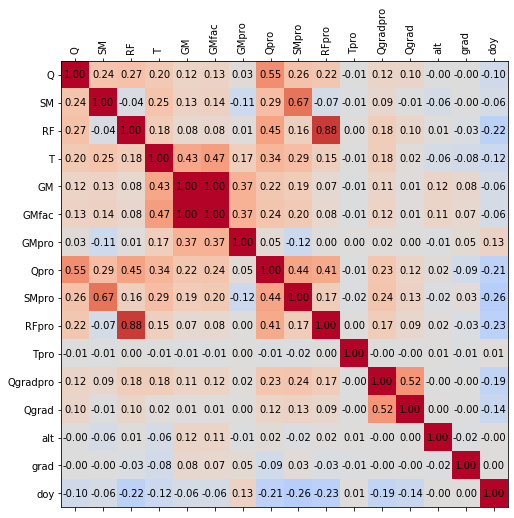

In [64]:
plotCorrMatrix(dfs["vest"]["all"].corr(),figsize=(8,8))

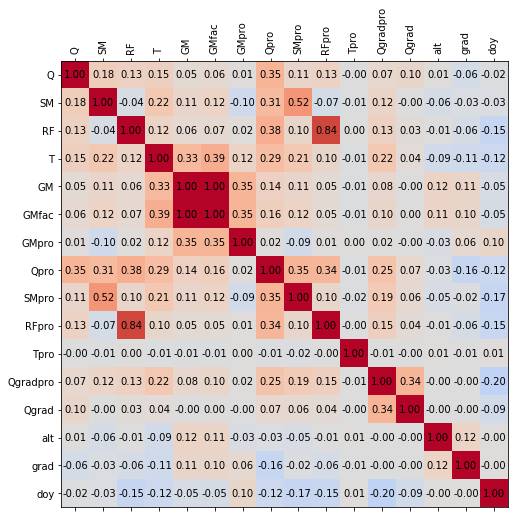

In [65]:
plotCorrMatrix(dfs["all"].corr(),figsize=(8,8))

# Individial catchments
## Trying out on single catchment

7700003
R²(adj): 0.5619683357953864

Intercept   -0.027677
RF           0.422449
SM           1.319018
T            0.080040
Qgrad        0.031903
dtype: float64


-1038.1894733988038

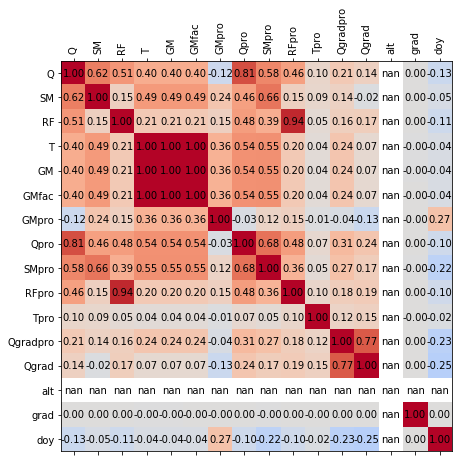

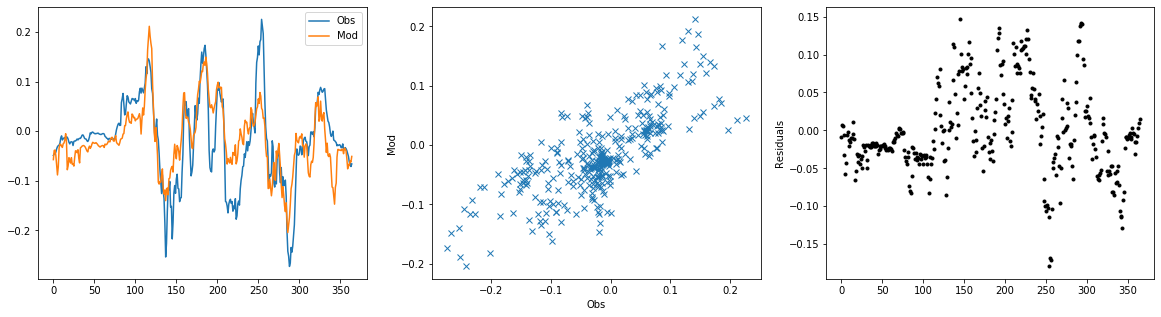

In [15]:
n = 30
region = "vest"
c = list(dfs["annual"][region].keys())[n]
print(c)
df = dfs["annual"][region][c]
pred = "Q"
if pred == "Q":
    formula = "Q ~ RF + SM + T + Qgrad"
elif pred == "Qpro":
    formula = "Qpro ~ RFpro + SMpro + T + Qgradpro"
model = ols(formula, df).fit()

plotCorrMatrix(df.corr())

fig,ax = plt.subplots(ncols=3,figsize=(20,5))
ax[0].plot(df[pred],label="Obs")
ax[0].plot(model.predict(),label="Mod")
ax[0].legend()

x = df[pred]
y = model.predict()
ax[1].plot(x,y,"x")
ax[1].set_xlabel("Obs")
ax[1].set_ylabel("Mod")

ax[2].plot(y-x,"k.")
ax[2].set_ylabel("Residuals")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

model.aic

## Calculating for catchments separately

In [16]:
formula = "Q ~ RF"
for region in ["ost","vest"]:
    for season in ["annual","winter","spring","summer","autumn"]:
        results = {}
        for c in dfs[season][region].keys():
            results[c] = {}
            df = dfs[season][region][c]
            model = ols(formula, df).fit()
            results[c]["rsquared_adj"] = model.rsquared_adj
            results[c]["intercept"] = model.params.Intercept
            results[c]["x1_rain"] = model.params.RF
            results[c]["aic"] = model.aic

        res = pd.DataFrame(results).T
        res.index.name = "snumber"
        res = res.iloc[:-1]
        res.to_csv(f"Results/OLS/multiregression_QRF_{region}_1983_2012_{season}.csv")

In [17]:
formula = "Q ~ SM"
for region in ["ost","vest"]:
    for season in ["annual","winter","spring","summer","autumn"]:
        results = {}
        for c in dfs[season][region].keys():
            results[c] = {}
            df = dfs[season][region][c]
            model = ols(formula, df).fit()
            results[c]["rsquared_adj"] = model.rsquared_adj
            results[c]["intercept"] = model.params.Intercept
            results[c]["x1_snow"] = model.params.SM
            results[c]["aic"] = model.aic

        res = pd.DataFrame(results).T
        res.index.name = "snumber"
        res = res.iloc[:-1]
        res.to_csv(f"Results/OLS/multiregression_QSM_{region}_1983_2012_{season}.csv")

In [18]:
formula = "Q ~ T"
for region in ["ost","vest"]:
    for season in ["annual","winter","spring","summer","autumn"]:
        results = {}
        for c in dfs[season][region].keys():
            results[c] = {}
            df = dfs[season][region][c]
            model = ols(formula, df).fit()
            results[c]["rsquared_adj"] = model.rsquared_adj
            results[c]["intercept"] = model.params.Intercept
            results[c]["x1_temp"] = model.params.T
            results[c]["aic"] = model.aic

        res = pd.DataFrame(results).T
        res.index.name = "snumber"
        res = res.iloc[:-1]
        res.to_csv(f"Results/OLS/multiregression_QT_{region}_1983_2012_{season}.csv")

In [59]:
dfs["winter"].keys()

dict_keys(['ost', 'vest'])

# All catchments

## Approach

* Regions should be considered separately
* Select calibration and validation dataset
* Variables to include:
    * snowmelt trend
    * rainfall trend
    * temperature trend
    * median altitude
    * 1+glaciation * temperature trend
    * catchment gradient

## Calibrating on all catchments

### Vestlandet

R²(adj): 0.34931879114296294

Intercept    0.000733
RFpro        0.285386
SMpro        0.278100
T            0.037101
GM           0.001076
grad        -0.000057
dtype: float64


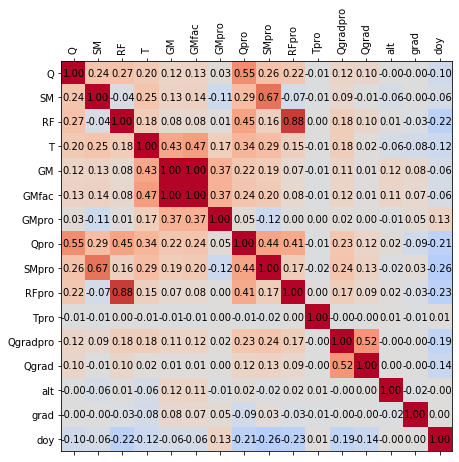

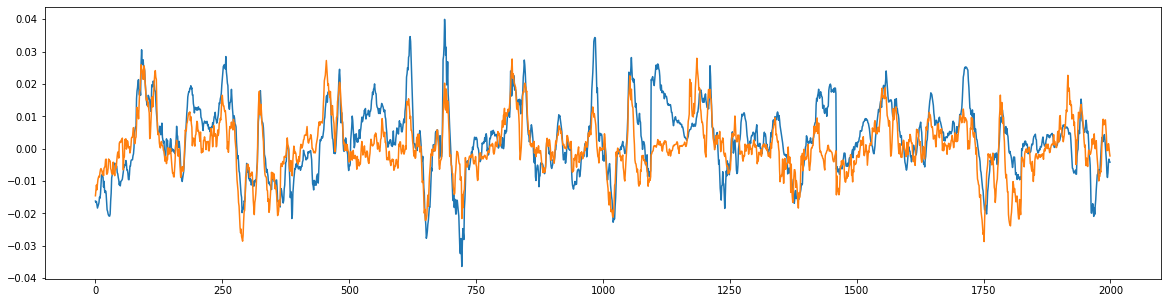

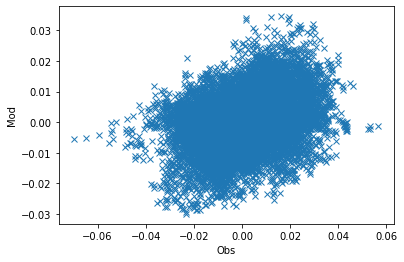

In [107]:
region = "vest"
formula = "Qpro ~ RFpro + SMpro + T + GM + grad" #+ Qgradpro

df = dfs[region]["all"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr)

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
obs = df.Qpro
mod = model.predict()
lim = np.min([mod.shape[0],obs.shape[0]])

plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

### Østlandet

R²(adj): 0.19262426060019544

Intercept    0.004005
RFpro        0.170932
SMpro        0.134975
T            0.025907
GM           0.002093
Qgradpro     0.085498
grad        -0.000026
dtype: float64


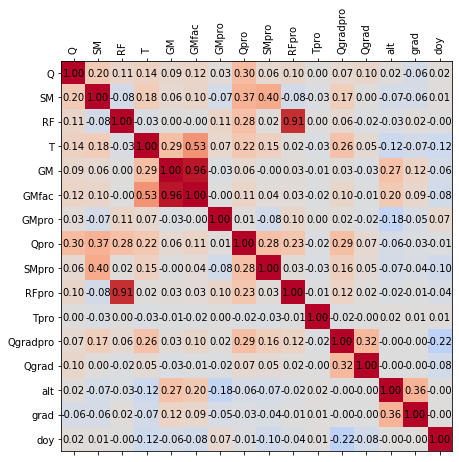

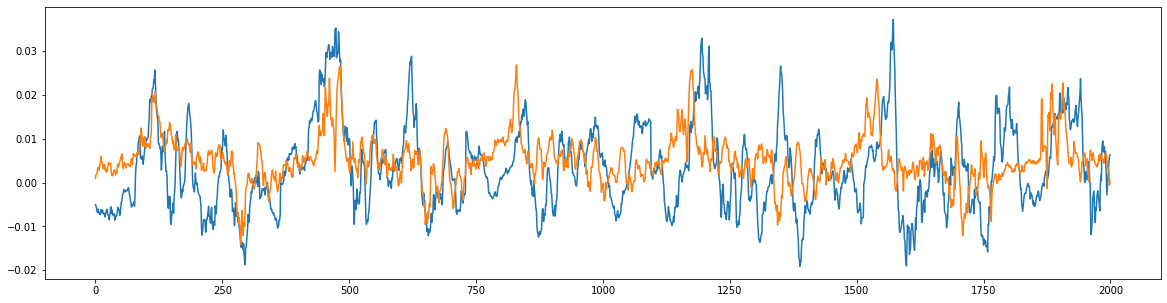

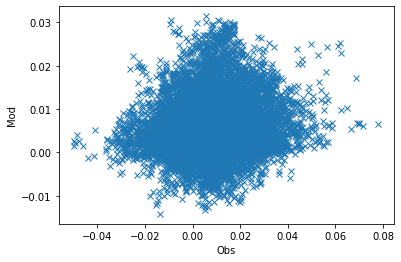

In [68]:
region = "ost"
formula = "Qpro ~ RFpro + SMpro + T + GM + Qgradpro + grad"

df = dfs[region]["all"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr)

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
obs = df.Qpro
mod = model.predict()
lim = np.min([mod.shape[0],obs.shape[0]])

plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

### All

R²(adj): 0.28181687437096214

Intercept    0.003268
RFpro        0.245983
SMpro        0.185990
T            0.035166
GM           0.001150
Qgradpro     0.054851
grad        -0.000102
dtype: float64


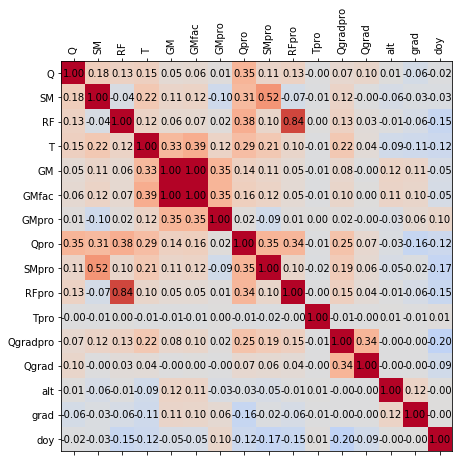

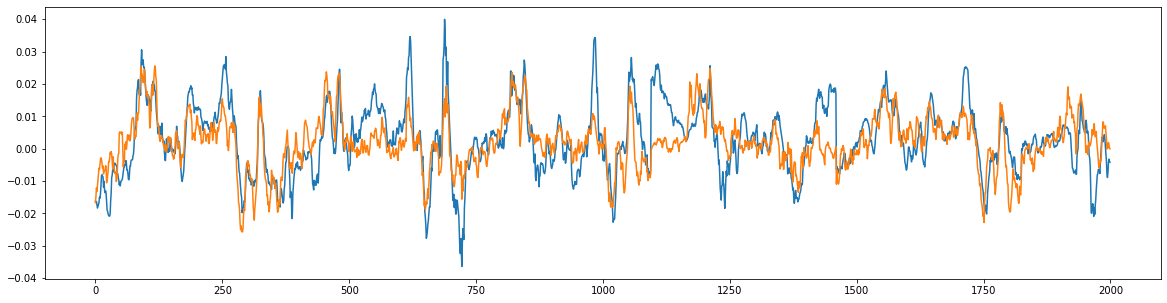

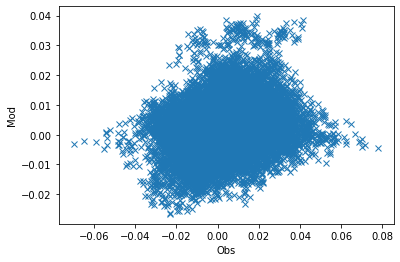

In [109]:
formula = "Qpro ~ RFpro + SMpro + T + GM + Qgradpro + grad"

df = dfs["all"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr)

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
obs = df.Qpro
mod = model.predict()
lim = np.min([mod.shape[0],obs.shape[0]])

plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

## Split calibration and validation

In [70]:
def getCalValCatchments(catchments,calProp = 0.3):
    N = len(catchments)
    Ncal = int(np.round(N*calProp))
    Nval = N-Ncal
    print(N, "catchments in total")
    print(Ncal, "calibration catchments")
    print(Nval, "validation catchments")

    cal = np.random.choice(range(N), Ncal, replace=False)
    calCatch = list(np.array(catchments)[cal])

    valCatch = []
    for c in catchments:
        if c in calCatch:
            continue
        else:
            valCatch.append(c)
    
    return calCatch,valCatch

### Vestlandet

In [71]:
region = "vest"
calCatch,valCatch = getCalValCatchments(data[region]["catchments"])

print(f"Calibration catchments:\n{calCatch}")
a = []
for c in calCatch:
    a.append((dfs[region][c]))
df = pd.concat(a).reset_index(drop=True)

a = []
for c in valCatch:
    a.append((dfs[region][c]))
dfVal = pd.concat(a).reset_index(drop=True)

61 catchments in total
18 calibration catchments
43 validation catchments
Calibration catchments:
[8100001, 7500028, 10500001, 8600010, 4800001, 8000004, 5500007, 3500009, 10300020, 7600011, 8500004, 9900017, 4800005, 5000001, 10900042, 7300001, 8400015, 8800004]


#### Calibration

In [72]:
formula = "Qpro ~ RFpro + SMpro + T + GM + Qgradpro + grad"

model = ols(formula, df).fit()

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

R²(adj): 0.3272782798306322

Intercept   -0.000543
RFpro        0.287297
SMpro        0.261661
T            0.037968
GM          -0.001444
Qgradpro     0.046105
grad        -0.000068
dtype: float64


#### Validation

NSE: 0.312
RMSE: 0.010 %


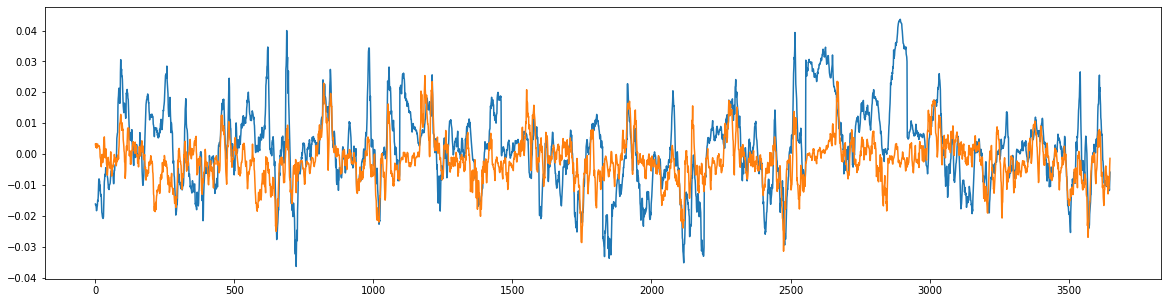

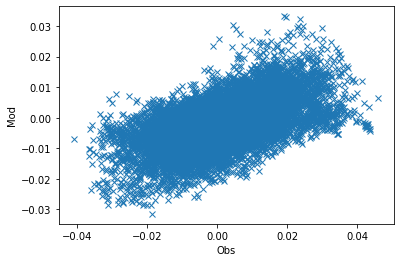

In [73]:
obs = dfVal.Qpro
mod = model.predict(exog=dfVal)

d = 365*10
plt.figure(figsize=(20,5))
plt.plot(obs.iloc[:d])
plt.plot(mod[:d])

plt.figure()
lim = np.min([mod.shape[0],obs.shape[0]])
plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print(f"NSE: {nse(mod,obs):.3f}")
print(f"RMSE: {rmse(mod,obs):.3f} %")

### Østlandet

In [74]:
region = "ost"
calCatch,valCatch = getCalValCatchments(data[region]["catchments"])

print(f"Calibration catchments:\n{calCatch}")
a = []
for c in calCatch:
    a.append((dfs[region][c]))
df = pd.concat(a).reset_index(drop=True)

a = []
for c in valCatch:
    a.append((dfs[region][c]))
dfVal = pd.concat(a).reset_index(drop=True)

51 catchments in total
15 calibration catchments
36 validation catchments
Calibration catchments:
[1600051, 31100460, 1600010, 1600075, 200032, 1600066, 1500053, 200279, 200291, 200267, 200025, 1200097, 1200137, 1600122, 600010]


#### Calibration

In [75]:
formula = "Qpro ~ RFpro + SMpro + T + GM + Qgradpro + grad"

model = ols(formula, df).fit()

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

R²(adj): 0.23408168142089336

Intercept    0.009194
RFpro        0.153974
SMpro        0.136042
T            0.021945
GM          -0.001240
Qgradpro     0.079740
grad        -0.000269
dtype: float64


#### Validation

NSE: 0.194
RMSE: 0.012 %


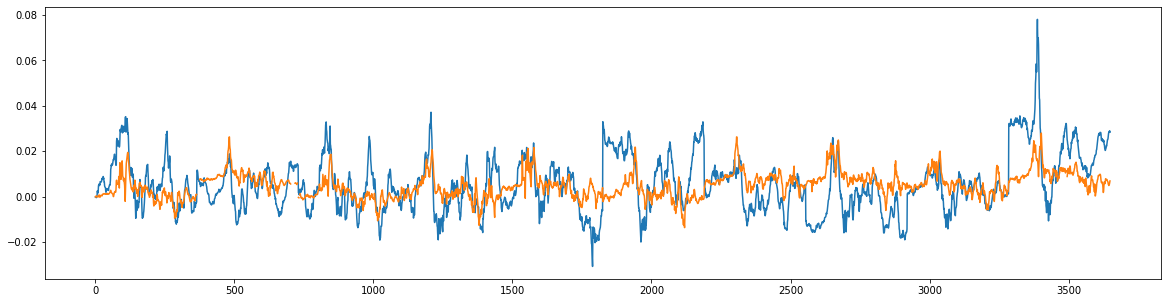

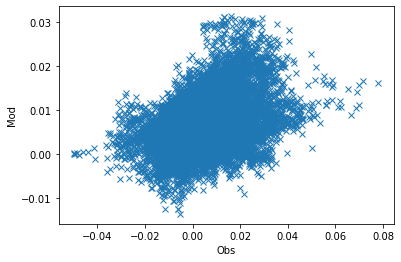

In [76]:
obs = dfVal.Qpro
mod = model.predict(exog=dfVal)

d = 365*10
plt.figure(figsize=(20,5))
plt.plot(obs.iloc[:d])
plt.plot(mod[:d])

plt.figure()
lim = np.min([mod.shape[0],obs.shape[0]])
plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print(f"NSE: {nse(mod,obs):.3f}")
print(f"RMSE: {rmse(mod,obs):.3f} %")

### All

In [104]:
calCatch,valCatch = getCalValCatchments(data["ost"]["catchments"]+data["vest"]["catchments"])

print(f"Calibration catchments:\n{calCatch}")

a = []
for c in calCatch:
    try:
        a.append((dfs["ost"][c]))
    except KeyError:
        a.append((dfs["vest"][c]))
dfCal = pd.concat(a).reset_index(drop=True)

a = []
for c in valCatch:
    try:
        a.append((dfs["ost"][c]))
    except KeyError:
        a.append((dfs["vest"][c]))
dfVal = pd.concat(a).reset_index(drop=True)

112 catchments in total
34 calibration catchments
78 validation catchments
Calibration catchments:
[200025, 200284, 600010, 200013, 1200193, 200616, 31100460, 1600075, 4600004, 200145, 3600013, 1600122, 1500053, 1200013, 5000001, 200028, 11100009, 7700003, 8200004, 8800004, 800002, 200323, 1200188, 10300020, 1500079, 7600005, 10900020, 1200113, 1200137, 4800005, 800006, 7500022, 3800001, 7300004]


#### Calibration

In [105]:
formula = "Qpro ~ RFpro + SMpro + T + GM" # + Qgradpro + grad

model = ols(formula, dfCal).fit()

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

R²(adj): 0.2748829441447014

Intercept    0.000935
RFpro        0.275730
SMpro        0.190731
T            0.049298
GM           0.000675
dtype: float64


#### Validaion

NSE: 0.313
RMSE: 0.011 %


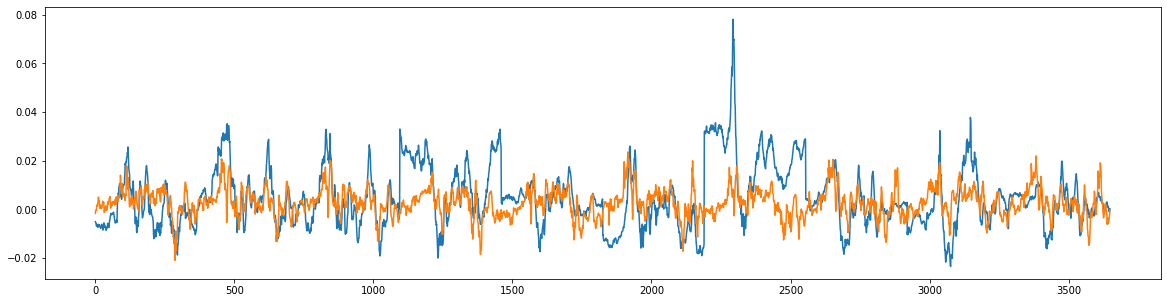

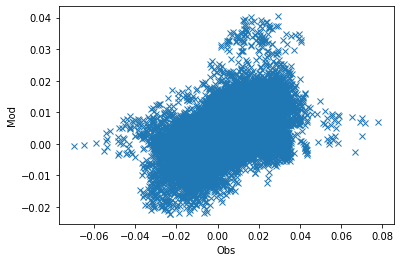

In [106]:
obs = dfVal.Qpro
mod = model.predict(exog=dfVal)

d = 365*10
plt.figure(figsize=(20,5))
plt.plot(obs.iloc[:d])
plt.plot(mod[:d])

plt.figure()
lim = np.min([mod.shape[0],obs.shape[0]])
plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print(f"NSE: {nse(mod,obs):.3f}")
print(f"RMSE: {rmse(mod,obs):.3f} %")

# Divided by altitude

High-altitude: > 1000 m

Mid-altitude: 500-1000 m

Low-altitude: < 500 m

In [80]:
catchmentsByAltitude = {}
for region in ["ost","vest"]:
    catchmentsByAltitude[region] = {}
    
    alt = np.array(data[region]["altitude"])
    catchm = np.array(data[region]["catchments"])
    # high
    mask = alt>1000
    catchmentsByAltitude[region]["high"] = catchm[mask]
    # mid
    mask = np.logical_and(alt<1000,alt>500)
    catchmentsByAltitude[region]["mid"] = catchm[mask]
    # low
    mask = alt<500
    catchmentsByAltitude[region]["low"] = catchm[mask]

In [81]:
catchmentsByAltitude

{'ost': {'high': array([ 200291,  200268,  200013,  200290, 1200013,  200284,  200025,
         1200197, 1200137, 1500079,  200032,  200614,  200145,  200129,
         1200097, 1500049, 1200099, 1500053, 1600066]),
  'mid': array([ 1200207,   200011,  1200070,   200607,  1600122,  1600075,
          1200171,  1200200,  1600010,   200028,  1200178, 31100460,
          1600051,   200604,   200267, 31100004, 31100006,  1200113,
          1200188,   200323,  1500021,   200280]),
  'low': array([1600194,  200279,  200142,  200616,  800002,  600010, 1200193,
          800006,  200633,  300022])},
 'vest': {'high': array([ 7600005,  4600009,  7500022, 10900009,  8800004,  7300004,
          9900017,  7300001,  7600011,  7600010,  7500028,  5000001,
          7200005, 10900021, 10300040,  4600004,  4800005,  5000003,
         10400002,  7800008, 10900042, 10900020,  8300007, 10900029,
          7500023, 10400022,  4800001,  8600012,  8700010,  8300006]),
  'mid': array([ 9800004,  7100001, 111

In [82]:
for region in ["ost","vest"]:
    for altReg in ["low","mid","high"]:
        a = []
        for c in catchmentsByAltitude[region][altReg]:
            a.append((dfs[region][c]))
        dfs[region][altReg] = pd.concat(a).reset_index(drop=True)

In [83]:
for altReg in ["low","mid","high"]:
    dfs[altReg] = pd.concat([dfs["ost"][altReg],dfs["vest"][altReg]]).reset_index(drop=True)

In [84]:
dfs.keys()

dict_keys(['ost', 'vest', 'all', 'low', 'mid', 'high'])

## High-altitude

### One region

R²(adj): 0.34438744463347404

Intercept    0.003729
RFpro        0.171558
SMpro        0.322433
T            0.018428
GM           0.001442
Qgradpro     0.024253
grad        -0.000122
dtype: float64


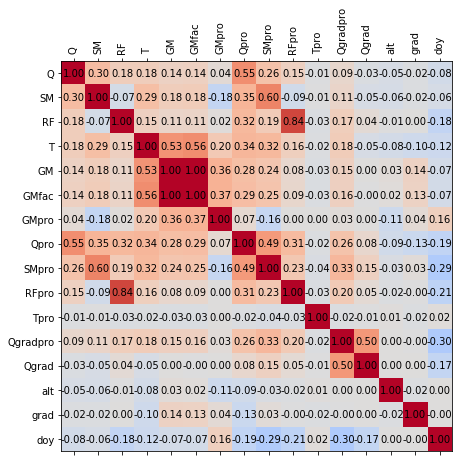

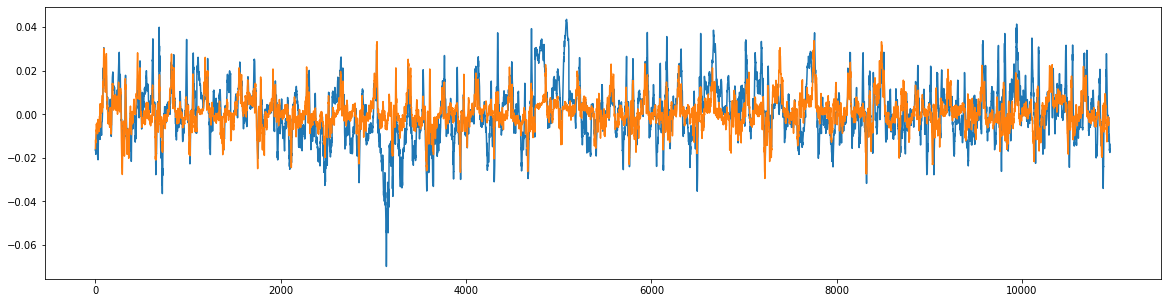

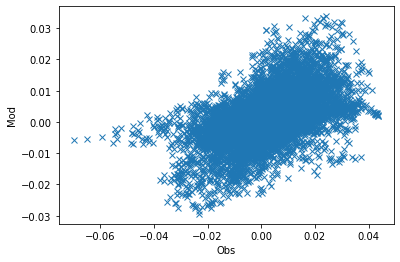

In [85]:
region = "vest"
altReg = "high"
formula = "Qpro ~ RFpro + SMpro + T + GM + Qgradpro + grad"

df = dfs[region][altReg]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr)

plt.figure(figsize=(20,5))
plt.plot(df.Qpro)
plt.plot(model.predict())

plt.figure()
obs = df.Qpro
mod = model.predict()
lim = np.min([mod.shape[0],obs.shape[0]])

plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

#### Both regions

## Mid-altitude

### Vestlandet

R²(adj): 0.4471916625637673

Intercept   -0.001268
RFpro        0.390066
SMpro        0.246939
T            0.043297
Qgradpro     0.018311
doy         -0.000003
dtype: float64


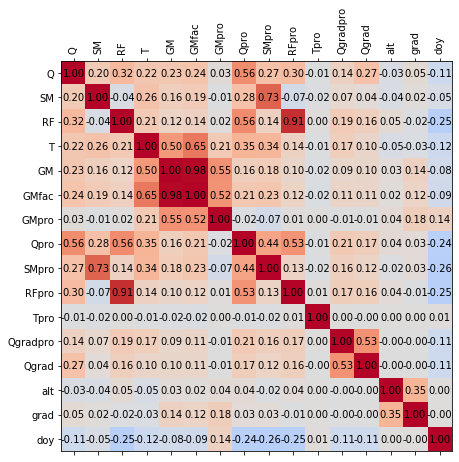

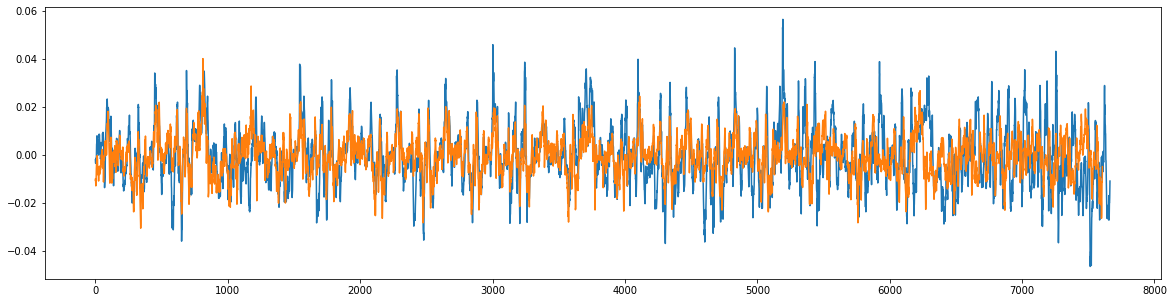

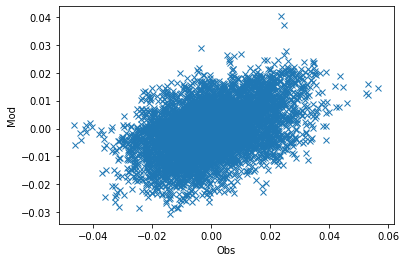

In [86]:
region = "vest"
altReg = "mid"
formula = "Qpro ~ RFpro + SMpro + T + Qgradpro + doy"

df = dfs[region][altReg]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr)

plt.figure(figsize=(20,5))
plt.plot(df.Qpro)
plt.plot(model.predict())

plt.figure()
obs = df.Qpro
mod = model.predict()
lim = np.min([mod.shape[0],obs.shape[0]])

plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

#### Østlandet

R²(adj): 0.21155304133192165

Intercept    0.003359
RFpro        0.265360
SMpro        0.106199
T            0.025403
Qgradpro     0.085050
doy          0.000007
dtype: float64


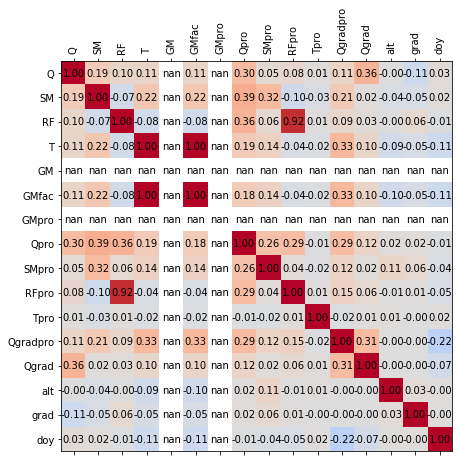

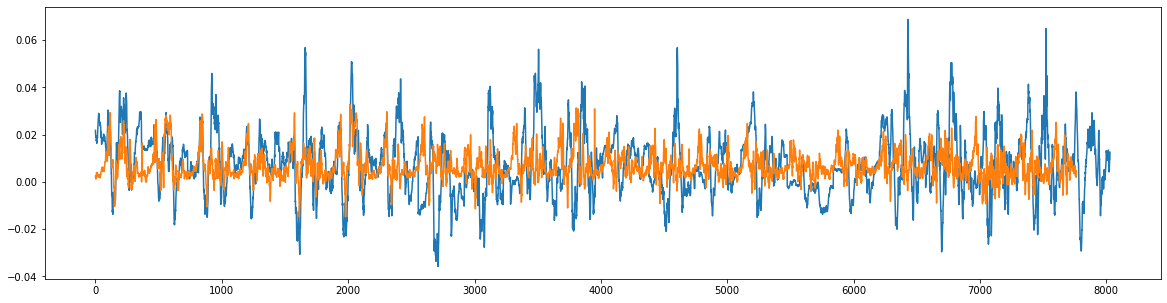

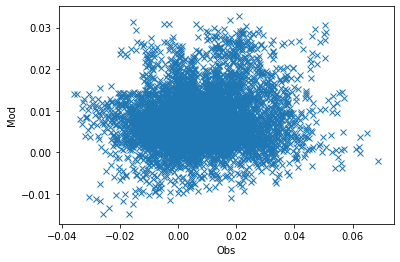

In [87]:
region = "ost"
altReg = "mid"
formula = "Qpro ~ RFpro + SMpro + T + Qgradpro + doy"

df = dfs[region][altReg]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr)

plt.figure(figsize=(20,5))
plt.plot(df.Qpro)
plt.plot(model.predict())

plt.figure()
obs = df.Qpro
mod = model.predict()
lim = np.min([mod.shape[0],obs.shape[0]])

plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

## Low-altitude

R²(adj): 0.3200470244518896

Intercept   -0.003257
RFpro        0.341287
SMpro        0.133921
T            0.055407
Qgradpro     0.061101
dtype: float64


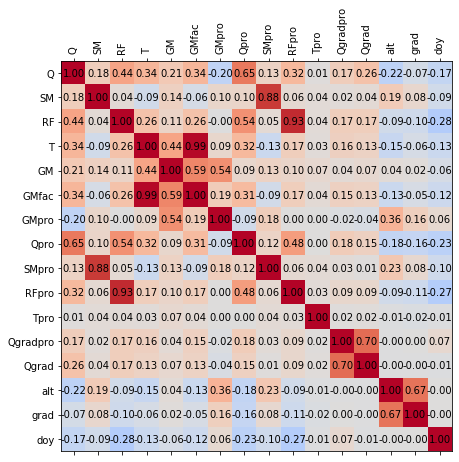

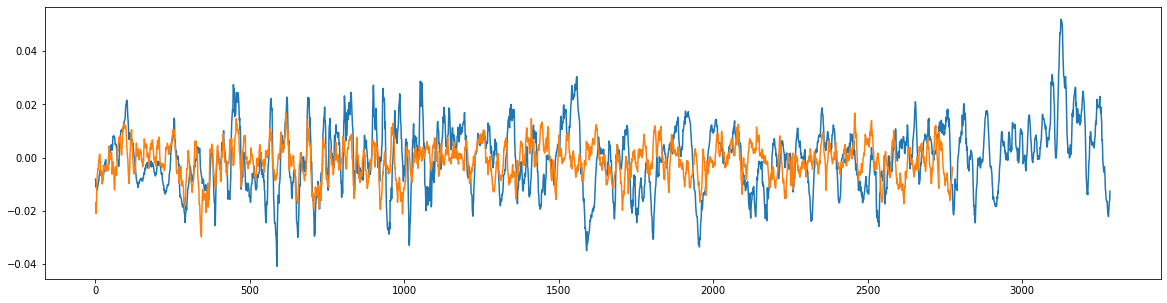

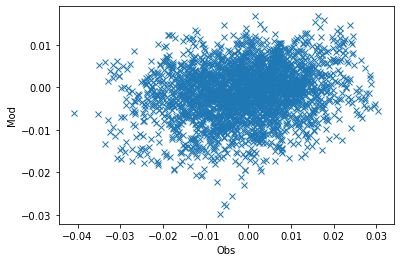

In [88]:
region = "vest"
altReg = "low"
formula = "Qpro ~ RFpro + SMpro + T + Qgradpro"

df = dfs[region][altReg]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr)

plt.figure(figsize=(20,5))
plt.plot(df.Qpro)
plt.plot(model.predict())

plt.figure()
obs = df.Qpro
mod = model.predict()
lim = np.min([mod.shape[0],obs.shape[0]])

plt.plot(obs.iloc[:lim],mod[:lim],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)
print()
print(model.params)

# Kormann et al. approach
## Original

Similar to Kormann et al. (2015), using Tmean instead of Tmin.

This approach, which is mainly based on temperature trend and first derivative of mean streamflow (i.e. annual hydrograph) does not appear to be suitable. This is likely due to the catchments here are at much lower altitudes where glaciers play a less important role. 

Should test whether the approach seems however to work reasonably well for the high-elevation catchments. 

In [89]:
formula = "Qpro ~ Qgrad + T + GM"

### By region

R²(adj): 0.1348569584304351


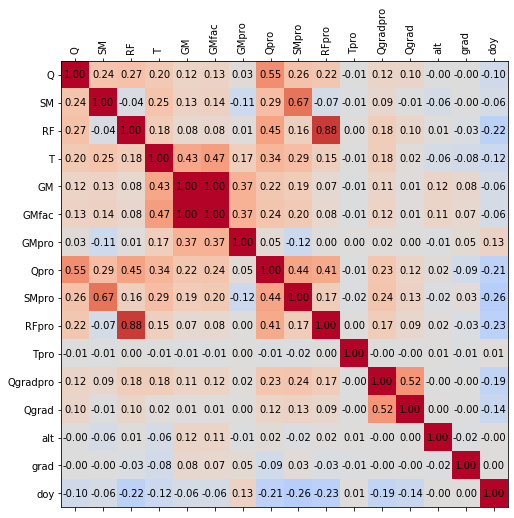

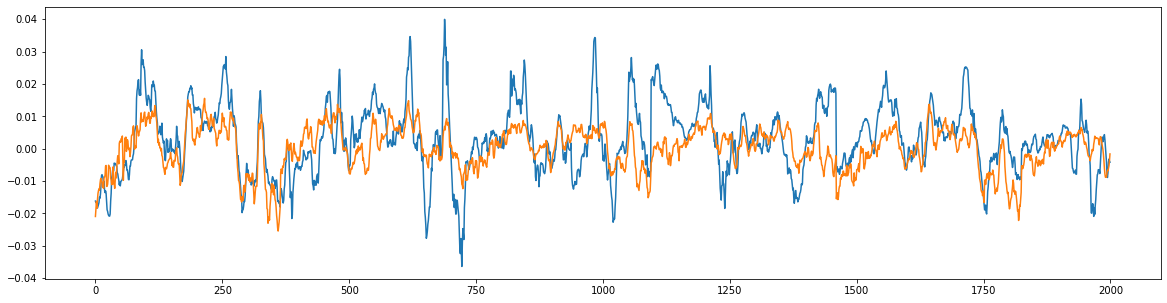

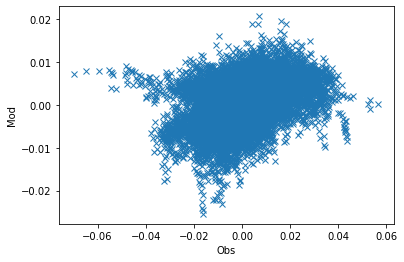

In [90]:
region = "vest"
#formula = "Qpro ~ Qgrad + T + GM"

df = dfs[region]["all"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr,figsize=(8,8))

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
plt.plot(df.Qpro.iloc[:17397],model.predict()[:17397],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)

## Only high altitude catchments

### All

R²(adj): 0.10439587242377002


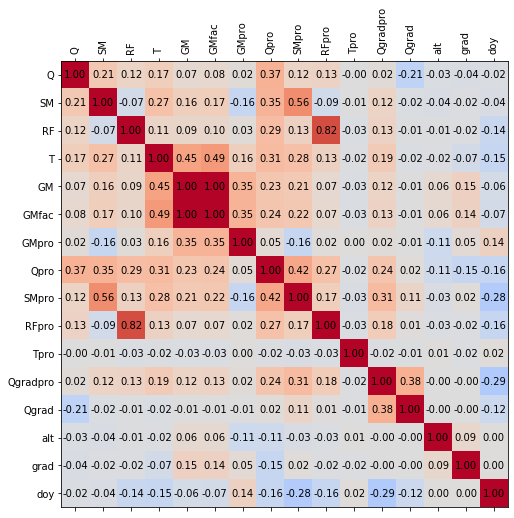

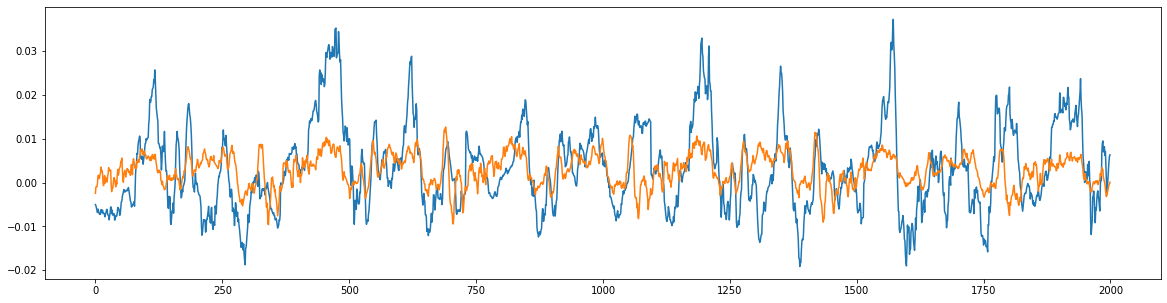

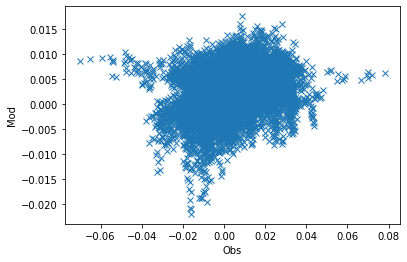

In [91]:
df = dfs["high"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr,figsize=(8,8))

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
plt.plot(df.Qpro.iloc[:17397],model.predict()[:17397],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)

### Vestlandet

R²(adj): 0.13737151778859702


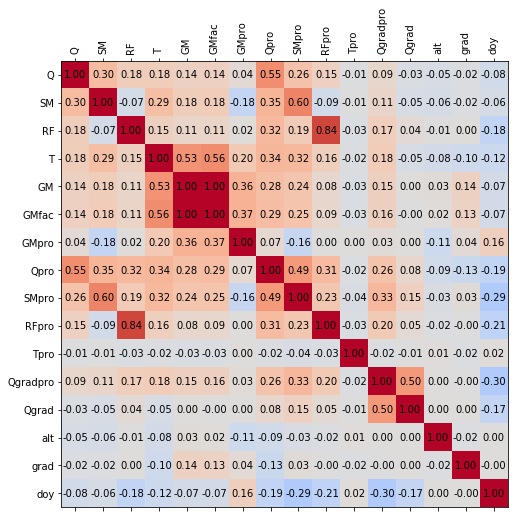

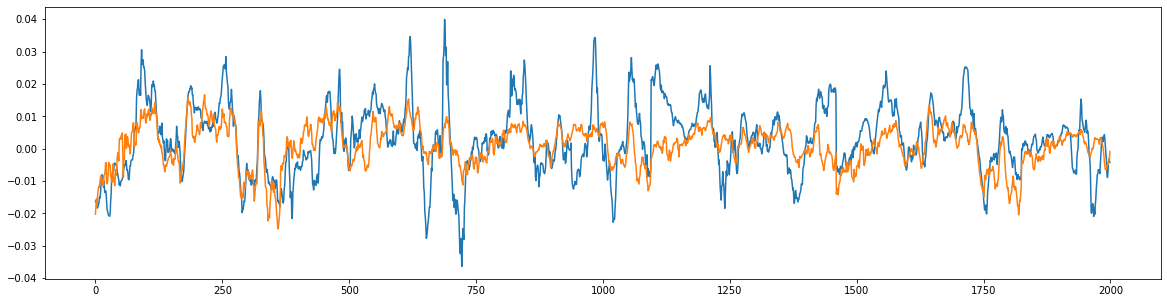

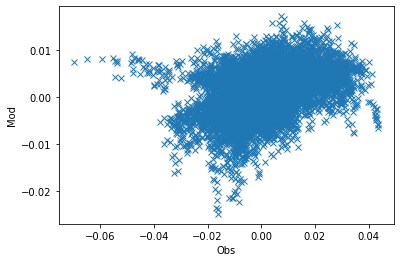

In [92]:
region = "vest"
df = dfs[region]["high"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr,figsize=(8,8))

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
plt.plot(df.Qpro.iloc[:17397],model.predict()[:17397],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)

### Østlandet

R²(adj): 0.06778812414206714


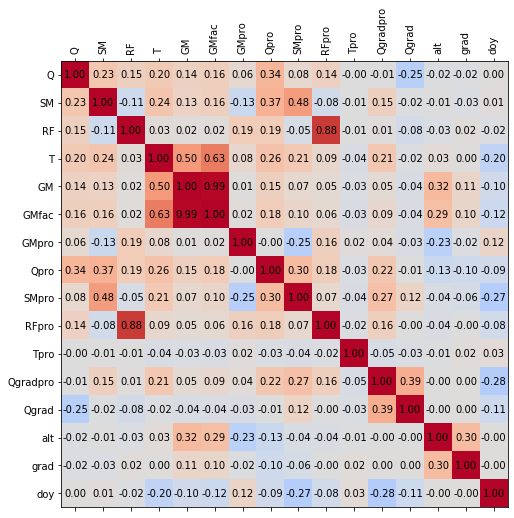

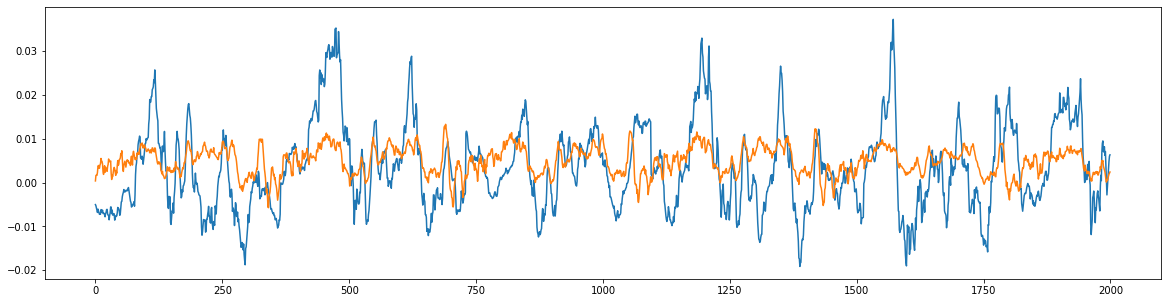

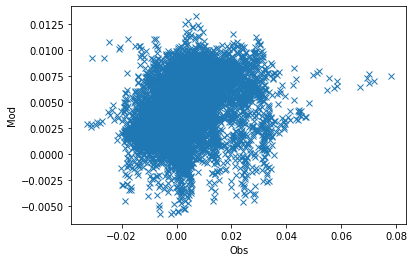

In [93]:
region = "ost"
df = dfs[region]["high"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr,figsize=(8,8))

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
plt.plot(df.Qpro.iloc[:17397],model.predict()[:17397],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)

## Modified

R²(adj): 0.3463626190749046


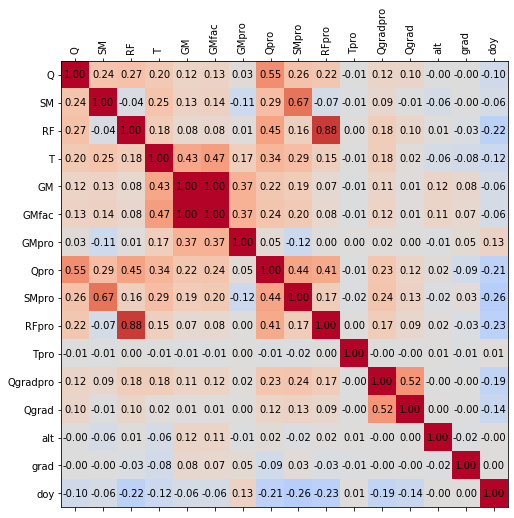

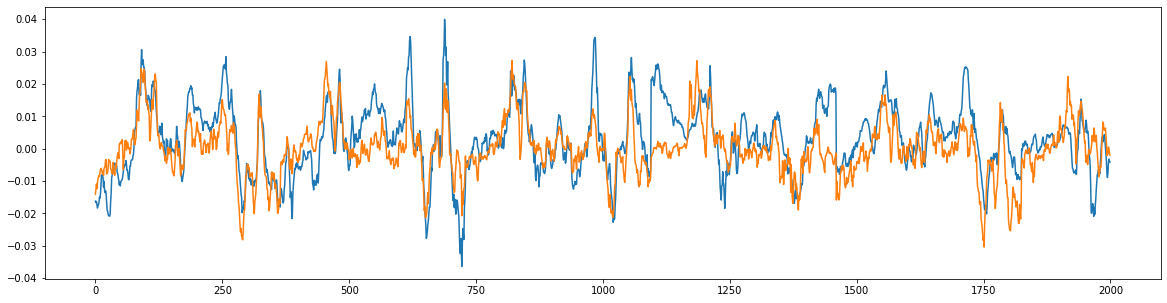

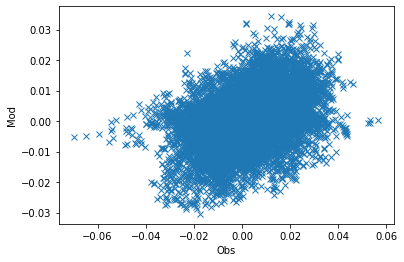

In [94]:
region = "vest"
formula = "Qpro ~ RFpro + SMpro + Qgrad + T + GM"
df = dfs[region]["all"]
model = ols(formula, df).fit()

corr = df.corr()
plotCorrMatrix(corr,figsize=(8,8))

d = 2000
plt.figure(figsize=(20,5))
plt.plot(df.Qpro.iloc[:d])
plt.plot(model.predict()[:d])

plt.figure()
plt.plot(df.Qpro.iloc[:17397],model.predict()[:17397],"x")
plt.xlabel("Obs")
plt.ylabel("Mod")

print("R²(adj):",model.rsquared_adj)